# 🤖  Mini-Transformer with NumPy: A Hands-On Tutorial

Author: Ioana Ciucă 

## Learning Objectives

By completing this tutorial, you will:
- Understand how to build a transformer step-by-step: tokenization -> embedding -> transformer block -> output logits.
- Implement a transformer with a single attention layer and no MLP layer  
- Visualize how attention works

Through this tutorial, you will implement the folllowing:
#### 1. **Tokenizer** 
Transform text into numbers that the model can process.

#### 2. **Embeddings**
- Token embeddings: Learn representations for each token.
- If we have time: Sinusoidal positional encoding, which tell the model about word order.

#### 3. **Single-Head Causal Self-Attention** 

- **Query ($W_Q$)**, **Key ($W_K$)**, **Value ($W_V$)** projections
- Attention scores with causal masking
- Softmax normalization
- Simple residual connections

#### 4. **Output Layer** 
Linear transformation to predict the next token.


## Imports & helpers

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

np.random.seed(42)

# 1. The Tokenizer 

Before a neural network can understand text, we need to convert words into numbers. This process, called **tokenization**, is the foundation of every language model, from BERT to GPT.

## How Our Simple Tokenizer Works

### 1. **Splitting Text into Tokens** 
We separate words and punctuation, treating each as its own unit:
- `"Hello, world!"` → `["hello", ",", "world", "!"]`
- Everything gets converted to lowercase for consistency for our example.
- Punctuation becomes separate tokens (important for understanding sentence structure!)

### 2. **Building a Vocabulary**
We scan all training texts and create a mapping:
```python
token_to_id = {
    "!": 0,
    ",": 1,
    ".":2,
    "hello": 3,
    "peace": 4,
    "world": 5,
    ...
}
```
Each unique token gets its own ID. The vocabulary only includes tokens seen during training.

### 3. **Encoding: Text → Numbers**
Convert any text into a sequence of IDs:
- `"Hello world!"` → `[3, 5, 0]`
- Unknown tokens (not in vocabulary) are skipped with a warning
- Example: `"Hello, world!"` → `[3, 1, 5, 0]` (Notice the comma. What if we didn't have the comma during training?)

### 4. **Decoding: Numbers → Text**
Reverse the process to see what the model "sees":
- `[3, 5, 0]` → `"hello world!"`
- Punctuation spacing is cleaned up for readability

## Key Points
- **No special tokens** for simplicity (no `<pad>`, `<bos>`, `<eos>`, `<unk>`)
- **Case-insensitive**: "Hello" and "hello" are the same token
- **Vocabulary-dependent**: Can only encode tokens seen during training

## Example Code

```python
# Build vocabulary from training texts
texts = ["Hello world!", "Hello there.", "World peace."]
token_to_id, id_to_token = build_vocab(texts)

# Encode a sentence
sentence = "Hello world!"
token_ids = encode(sentence, token_to_id)
# Result: [3, 5, 0]

# Decode back to text
decoded = decode(token_ids, id_to_token)
# Result: "hello world!"
```

## Why This Matters

1. **Foundation for embeddings**: Each token ID will map to an embedding vector
2. **Consistent representation**: Same word always gets same ID
3. **Handles punctuation**: Periods, commas, etc. are important for meaning
4. **Simple to understand**: No complex subword tokenization (like Byte-Pair Encoding or WordPiece)

In [2]:
def tokenize(text):
    """Split text into tokens, handling punctuation"""
    # Convert to lowercase
    text = text.lower()

    # Add spaces around punctuation
    punct = '.,!?;:"()[]{}'
    for p in punct:
        text = text.replace(p, f' {p} ')

    # Split on spaces and remove empty strings
    tokens = text.split()
    return tokens

def build_vocab(texts):
    """Build vocabulary from list of texts"""
    vocab = set()
    for text in texts:
        tokens = tokenize(text)
        vocab.update(tokens)

    # Sort for consistent ordering; Python sorts strings alphabetically
    sorted_vocab = sorted(list(vocab))

    # Create mappings
    token_to_id = {token: i for i, token in enumerate(sorted_vocab)}
    id_to_token = {i: token for i, token in enumerate(sorted_vocab)}

    return token_to_id, id_to_token

def encode(text, token_to_id):
    """Convert text to list of token IDs"""
    tokens = tokenize(text)
    ids = []
    unknown_tokens = []

    for token in tokens:
        if token in token_to_id:
            ids.append(token_to_id[token])
        else:
            # For teaching purposes, let's track what's unknown
            unknown_tokens.append(token)

    if unknown_tokens:
        print(f"  Warning: Unknown tokens skipped: {unknown_tokens}")

    return np.array(ids, dtype=np.int32)

def decode(ids, id_to_token):
    """Convert list of token IDs back to text"""
    tokens = [id_to_token[id] for id in ids] # a bit of a list comprehension

    # Join tokens with spaces
    text = " ".join(tokens)

    # Clean up spacing around punctuation for readability
    punct = '.,!?;:"()[]{}'
    for p in punct:
        text = text.replace(f' {p}', p)

    return text

### Try it out :)

In [3]:
# Example usage
texts = ["Hello, world!", "Hello there.", "World peace.", "The cat sat on the mat."]

# Build vocabulary
token_to_id, id_to_token = build_vocab(texts)
print(f"Vocabulary size: {len(token_to_id)}")
print(f"Token to id mapping: {token_to_id}")
print(f"Id to token mapping: {id_to_token}")

Vocabulary size: 12
Token to id mapping: {'!': 0, ',': 1, '.': 2, 'cat': 3, 'hello': 4, 'mat': 5, 'on': 6, 'peace': 7, 'sat': 8, 'the': 9, 'there': 10, 'world': 11}
Id to token mapping: {0: '!', 1: ',', 2: '.', 3: 'cat', 4: 'hello', 5: 'mat', 6: 'on', 7: 'peace', 8: 'sat', 9: 'the', 10: 'there', 11: 'world'}


In [4]:

# Encode a sentence
sentence = "Hello, world!"
ids = encode(sentence, token_to_id)
print(f"\nOriginal: {sentence}")
print(f"Token IDs: {ids}")



Original: Hello, world!
Token IDs: [ 4  1 11  0]


In [5]:
# Decode back

ids = [4, 1, 11, 0]
decoded = decode(ids, id_to_token)
print(f"Decoded: {decoded}")

Decoded: hello, world!


## We can build and understand a tiny astronomy corpus.

In [6]:
texts = [
    "O B A F G K M O B A F G K M O B A F G K M .",
    "Mercury Venus Earth Mars Jupiter Saturn Uranus Neptune .",
    "The Sun is a G type star in the Milky Way .",
    "Betelgeuse is an M type star .",
    "Rigel is a B type star .",
    "Sirius is an A type star .",
    "Andromeda is also called M31 ."
]

token_to_id, id_to_token =  build_vocab(texts) #TODO: add your code here
vocab_size = len(token_to_id)

print("Vocab size:", vocab_size)
print(f"First 20 tokens: {list(token_to_id.items())[:20]}")

Vocab size: 32
First 20 tokens: [('.', 0), ('a', 1), ('also', 2), ('an', 3), ('andromeda', 4), ('b', 5), ('betelgeuse', 6), ('called', 7), ('earth', 8), ('f', 9), ('g', 10), ('in', 11), ('is', 12), ('jupiter', 13), ('k', 14), ('m', 15), ('m31', 16), ('mars', 17), ('mercury', 18), ('milky', 19)]


In [7]:
# Install: pip install tiktoken
import tiktoken

def demo_real_tokenization():
    """Show how GPT actually tokenizes text"""

    # Get GPT-2's tokenizer
    enc = tiktoken.get_encoding("gpt2")

    # Example text
    text = "The Sun is a G type star in the Milky Way."

    # Tokenize
    tokens = enc.encode(text)

    print("Original text:", text)
    print(f"Token IDs: {tokens}")
    print(f"Number of tokens: {len(tokens)}")

    # Show each token
    print("\nToken breakdown:")
    for token_id in tokens:
        token_str = enc.decode([token_id])
        print(f"  {token_id:5d} → '{token_str}'")


    # Show subword tokenization
    interesting_words = [
        "unbelievable",
        "artificial",
        "consciousness",
        "Mars",
        "M31"
    ]

    print("How GPT-2 splits words:")
    for word in interesting_words:
        tokens = enc.encode(word)
        pieces = [enc.decode([t]) for t in tokens]
        print(f"  '{word}' → {pieces}")

# Run the demo
demo_real_tokenization()

Original text: The Sun is a G type star in the Milky Way.
Token IDs: [464, 3825, 318, 257, 402, 2099, 3491, 287, 262, 34822, 6378, 13]
Number of tokens: 12

Token breakdown:
    464 → 'The'
   3825 → ' Sun'
    318 → ' is'
    257 → ' a'
    402 → ' G'
   2099 → ' type'
   3491 → ' star'
    287 → ' in'
    262 → ' the'
  34822 → ' Milky'
   6378 → ' Way'
     13 → '.'
How GPT-2 splits words:
  'unbelievable' → ['un', 'bel', 'iev', 'able']
  'artificial' → ['art', 'ificial']
  'consciousness' → ['conscious', 'ness']
  'Mars' → ['Mars']
  'M31' → ['M', '31']


In [8]:
print("Our Simple Tokenizer:")
print(f"Vocabulary size: {vocab_size}")
print(f"Tokens for 'The Sun': {encode('The Sun', token_to_id)}")

print("How GPT-2 Would Tokenize:")
enc = tiktoken.get_encoding("gpt2")
print(f"Vocabulary size: {enc.n_vocab}")  # 50,257!
print(f"Tokens for 'The Sun': {enc.encode('The Sun')}")

Our Simple Tokenizer:
Vocabulary size: 32
Tokens for 'The Sun': [27 26]
How GPT-2 Would Tokenize:
Vocabulary size: 50257
Tokens for 'The Sun': [464, 3825]


## Problem 1: Exploring Your Tokenizer

You've built a tokenizer using the tiny astronomy corpus.

You are now give these two sentences.

```python
test_sentences = [
    "The Sun .",
    "the sun .",
    "Betelgeuse is a star .",
    "Proxima Centauri is a star .",
    "A B C D E F G ."
]
```
1. **Encode patterns**: Encode these test sentences and determine if the first two sentences produce the same results. What would we need for them to produce different results?


In [ ]:
# TODO: add your code here
token_to_id, id_to_token = build_vocab(texts)


## 2. Embeddings + (Extra) Sinusoidal Positional Encoding

Remember our tokens `[5, 87, 42]`? These numbers don't mean anything to a neural network yet. We need to convert each token into a **vector** that can capture meaning.

Think of it like this:
- Token ID `5` (maybe "cat") → `[0.2, -0.1, 0.8, ...]` 
- Token ID `87` (maybe "dog") → `[0.3, -0.2, 0.7, ...]`

These vectors can learn that "cat" and "dog" are similar (both animals) in some high-dimensional vector space where they point in a similar direction (small-ish angle between them).

## The Problem with Order

Transformers process multiple tokens at once. But word order matters!
- "The cat ate the mouse" ≠ "The mouse ate the cat" 🐱🐭

**Solution:** Add position information to each embedding using **sinusoidal positional encoding**.

### The Math

For each position `pos` and dimension `i` in the embedding:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

Where:
- `pos` = position of tokens in the sequence (0, 1, 2, ...)
- `i` = dimension index (0, 1, 2, ..., d_model/2)
- `d_model` = embedding dimension (e.g., 512 or for our example, 4. Powers of 2 are particularly nice to GPUs.)

**In simple terms:**
- Even dimensions use `sin`, odd dimensions use `cos`
- Each dimension oscillates at a different frequency
- This creates a unique "fingerprint" for each position!

**Final embedding** = Token embedding + Positional encoding

Big thanks to  Mehreen Saeed for this wonderful visualisation of positional encodings: https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/

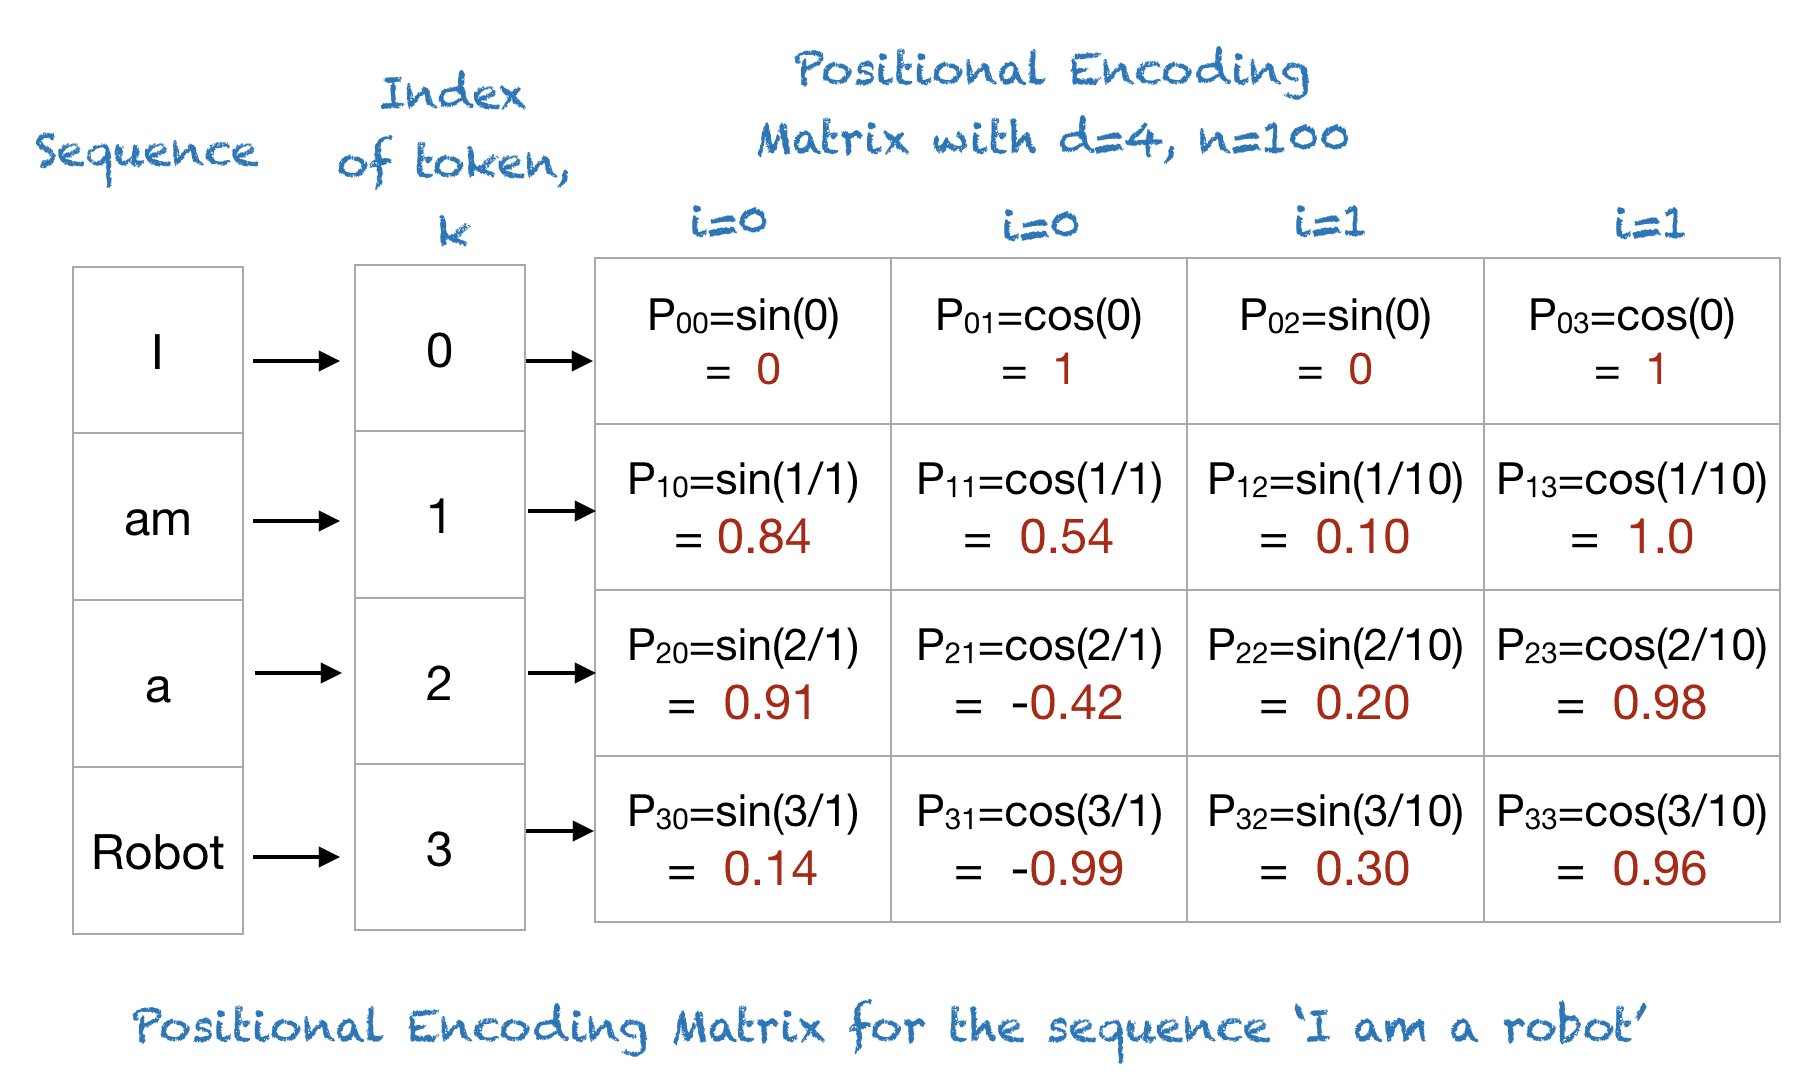

In [ ]:
# Display the positional encoding diagram
display(Image("pos-enc.png", width=800))

In [11]:
def create_embeddings(vocab_size, embedding_dim=4):
    """Create random embeddings for each word"""

    embeddings = np.random.randn(vocab_size, embedding_dim) * 0.5 #we're scaling down the random values to be more restricted in range
    return embeddings

def sinusoidal_positional_encoding(T, d_model):
    """Create unique position vectors using sine/cosine waves"""
    pe = np.zeros((T, d_model), dtype=np.float32)

    # For each position in the sequence
    for pos in range(T):
        # For each dimension of the embedding
        for i in range(0, d_model, 2):
            # Calculate the divisor for this dimension
            # This creates different frequencies for different dimensions
            divisor = 10000.0 ** (i / d_model)

            # Apply sine to even dimensions
            pe[pos, i] = np.sin(pos / divisor)

            # Apply cosine to odd dimensions (if not last dimension)
            if i + 1 < d_model:
                pe[pos, i + 1] = np.cos(pos / divisor)

    return pe

def embed(token_ids, W_E, PE=None):
    """
    Get embeddings for tokens, optionally adding positional information

    Args:
        token_ids: List or array of token IDs
        W_E: Embedding matrix (vocab_size, embedding_dim)
        PE: Positional encoding matrix (max_seq_len, embedding_dim) or None

    Returns:
        Embeddings with or without positional encoding
    """
    embeddings = W_E[token_ids] # picks the rows of W_E that correspond to the token ids

    if PE is not None:
        # Add positional encoding if provided
        embeddings = embeddings + PE[:len(token_ids)] # adds the positional encoding to the embeddings

    return embeddings

## Problem 2: Explore embeddings with a simple corpus of two sentences.

In [9]:
# Build vocabulary
sentences = ["the cat sat on the mat", "The dog sat on the log"]
word_to_id, id_to_token = build_vocab(sentences)

print("VOCABULARY")
print("=" * 60)
for word, word_id in sorted(word_to_id.items()):
    print(f"  '{word}' -> {word_id}")
print(f"\nTotal vocabulary size: {len(word_to_id)}")

VOCABULARY
  'cat' -> 0
  'dog' -> 1
  'log' -> 2
  'mat' -> 3
  'on' -> 4
  'sat' -> 5
  'the' -> 6

Total vocabulary size: 7


In [12]:
# Create embedding matrix (W_E)
vocab_size = len(word_to_id)
W_E = create_embeddings(vocab_size, embedding_dim=4)

print(f"\nEMBEDDING MATRIX (W_E)")
print("=" * 60)
print(f"Shape: {W_E.shape} (vocab_size={vocab_size}, dim=4)")
print(f"This is W_E! Each row is a word's embedding vector.")
print(f"\nFirst 3 embeddings:")
for i in range(min(3, vocab_size)):
    print(f"  Token {i} ('{id_to_token[i]}'):",
          f"[{W_E[i,0]:6.3f}, {W_E[i,1]:6.3f}, {W_E[i,2]:6.3f}, {W_E[i,3]:6.3f}]")



EMBEDDING MATRIX (W_E)
Shape: (7, 4) (vocab_size=7, dim=4)
This is W_E! Each row is a word's embedding vector.

First 3 embeddings:
  Token 0 ('cat'): [ 0.248, -0.069,  0.324,  0.762]
  Token 1 ('dog'): [-0.117, -0.117,  0.790,  0.384]
  Token 2 ('log'): [-0.235,  0.271, -0.232, -0.233]


In [ ]:
# Create positional encodings
PE = sinusoidal_positional_encoding(T=100, d_model=4)

print(f"\nPOSITIONAL ENCODING (PE)")
print("=" * 60)
print(f"Shape: {PE.shape} (max_seq_len=100, dim=4)")
print(f"First 3 position encodings:")
for pos in range(3):
    print(f"  Position {pos}: [{PE[pos,0]:6.3f}, {PE[pos,1]:6.3f}, {PE[pos,2]:6.3f}, {PE[pos,3]:6.3f}]")


POSITIONAL ENCODING (PE)
Shape: (100, 4) (max_seq_len=100, dim=4)
First 3 position encodings:
  Position 0: [ 0.000,  1.000,  0.000,  1.000]
  Position 1: [ 0.841,  0.540,  0.010,  1.000]
  Position 2: [ 0.909, -0.416,  0.020,  1.000]


In [14]:
# Convert a sentence to embeddings
sentence = "the cat sat on the mat"
words = tokenize(sentence)

print(f"\nPROCESSING SENTENCE: '{sentence}'")

print(f"words: {words}")
word_ids = [word_to_id[word] for word in words]
print(f"word_ids: {word_ids}")



PROCESSING SENTENCE: 'the cat sat on the mat'
words: ['the', 'cat', 'sat', 'on', 'the', 'mat']
word_ids: [6, 0, 5, 4, 6, 3]


In [15]:
#  Using embed() WITHOUT positional encoding
print(f"\nMETHOD 1: USING embed() WITHOUT POSITIONAL ENCODING")
print("-" * 40)
embeddings_no_pe = embed(word_ids, W_E)

print(f"embeddings = embed(word_ids, W_E)")
print(f"Shape: {embeddings_no_pe.shape}")
print(f"embedding of {words[0]}: {embeddings_no_pe[0]}")
print(f"embedding of {words[1]}: {embeddings_no_pe[1]}")
print(f"embedding of {words[2]}: {embeddings_no_pe[2]}")
print(f"embedding of {words[3]}: {embeddings_no_pe[3]}")
print(f"embedding of {words[4]}: {embeddings_no_pe[4]}")
print(f"embedding of {words[5]}: {embeddings_no_pe[5]}")



METHOD 1: USING embed() WITHOUT POSITIONAL ENCODING
----------------------------------------
embeddings = embed(word_ids, W_E)
Shape: (6, 4)
embedding of the: [-0.27219136  0.05546129 -0.57549679  0.18784901]
embedding of cat: [ 0.24835708 -0.06913215  0.32384427  0.76151493]
embedding of sat: [ 0.73282438 -0.11288815  0.0337641  -0.71237409]
embedding of on: [-0.50641556  0.15712367 -0.45401204 -0.70615185]
embedding of the: [-0.27219136  0.05546129 -0.57549679  0.18784901]
embedding of mat: [ 0.12098114 -0.95664012 -0.86245892 -0.28114376]


In [17]:
#  Using embed() WITH positional encoding
print(f"\nMETHOD 2: USING embed() WITH POSITIONAL ENCODING")
print("-" * 40)
embeddings_with_pe = embed(word_ids, W_E, PE)
print(f"embeddings = embed(word_ids, W_E, PE)")
print(f"Shape: {embeddings_with_pe.shape}")



METHOD 2: USING embed() WITH POSITIONAL ENCODING
----------------------------------------
embeddings = embed(word_ids, W_E, PE)
Shape: (6, 4)


### Q2.1 Compare the embeddings of the token "the" at positions 0 and 4. Are they the same when using positional encoding? What about without positional encoding?



In [31]:
# TODO: Your code here

### For more info of the embedding, you can have a more in depth read here.

https://alessiodevoto.github.io/LLM-Embedding-Space/

## The Embedding Matrix 

### Let us pretend we have trained our model and that we have a tokenizer that treats "The" and "the" as tokens with different embeddings. We obtained the values inside $W_E$ after training.

In [18]:
# Define the words in our sentence
words = ['The', 'cat', 'sat', 'on', 'the', 'mat']

# Create simple embeddings for each word
embeddings = np.array([
    [1.0, 0.0, 0.0, 0.0],  # The
    [0.0, 1.0, 0.0, 0.0],  # cat
    [0.0, 0.0, 0.5, 0.0],  # sat
    [0.0, 0.0, 0.0, 1.0],  # on
    [0.5, 0.5, 0.0, 0.0],  # the (lowercase)
    [0.0, 0.5, 0.5, 0.0],  # mat
])

print("EMBEDDINGS")
print("=" * 50)
for i, word in enumerate(words):
    print(f"{word:3s}: {embeddings[i]}")

print(f"\nEmbedding matrix shape: {embeddings.shape}")
print(f"  -> {embeddings.shape[0]} tokens in the sentence")
print(f"  -> {embeddings.shape[1]} dimensions per embedding")

EMBEDDINGS
The: [1. 0. 0. 0.]
cat: [0. 1. 0. 0.]
sat: [0.  0.  0.5 0. ]
on : [0. 0. 0. 1.]
the: [0.5 0.5 0.  0. ]
mat: [0.  0.5 0.5 0. ]

Embedding matrix shape: (6, 4)
  -> 6 tokens in the sentence
  -> 4 dimensions per embedding


### Understanding W_E vs Sentence Embeddings

#### When we see this code, there may be some confusion.

```python
embeddings = np.array([
    [1.0, 0.0, 0.0, 0.0],  # The
    [0.0, 1.0, 0.0, 0.0],  # cat
    [0.0, 0.0, 0.5, 0.0],  # sat
    [0.0, 0.0, 0.0, 1.0],  # on
    [0.5, 0.5, 0.0, 0.0],  # the
    [0.0, 0.5, 0.5, 0.0],  # mat
])
```

**This is NOT W_E!** This is already the result of looking up words in W_E.

##### W_E (Embedding Matrix)
- **What it is**: The full vocabulary embedding matrix
- **Shape**: `(vocab_size, embedding_dim)`
- **Contains**: Embeddings for ALL words in vocabulary
- **Example**: If vocab has 1000 words, W_E is `(1000, 4)`

##### Sentence Embeddings
- **What it is**: Embeddings for words in a specific sentence
- **Shape**: `(sentence_length, embedding_dim)`
- **Contains**: Only embeddings for words in this sentence
- **Example**: For 6-word sentence, embeddings is `(6, 4)`


## 3. The Attention Mechanism: a fully worked example

Huge thanks to Thomas Wiecki for this awesome resource: https://twiecki.io/blog/2024/01/04/

W_q: Transforms input → "What am I looking for?"

W_k: Transforms input → "What do I have to offer?"

```
Q = Input @ W_q
K = Input @ W_k
Attention = Q @ K^T/sqrt(d_K)
```

High score = words should attend to each other

Let's take our canonical example "The cat sat on the mat".

In [21]:
words = ['The', 'cat', 'sat', 'on', 'the', 'mat']

# Create simple embeddings for each word; we assume that we have already trained our model
# and that we have a tokenizer that treats "The" and "the" as tokens with different embeddings.
# We obtained the values inside $W_E$ after training.
embeddings = np.array([
    [1.0, 0.0, 0.0, 0.0],  # The
    [0.0, 1.0, 0.0, 0.0],  # cat
    [0.0, 0.0, 0.5, 0.0],  # sat
    [0.0, 0.0, 0.0, 1.0],  # on
    [0.5, 0.5, 0.0, 0.0],  # the (lowercase)
    [0.0, 0.5, 0.5, 0.0],  # mat
])

input_sequence = embeddings  # All 6 words in order
print(input_sequence) #notice this is our sentence embeddings for "The cat sat on the mat"

[[1.  0.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  1. ]
 [0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]]


In [22]:
# These are hand-crafted to show how 'cat' and 'mat' can find each other
# This is W_q, the query projection matrix
# first column is the query projection for 'The', second for 'cat', etc.
W_q = np.array([[0.5, 0.0, 0.0, 0.0, 1.0, 0.0],
                [0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
                [0.0, 1.0, 0.5, 0.0, 0.0, 1.0],
                [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]])

# Define weight matrices for keys
# first column is the key projection for 'The', second for 'cat', etc.
W_k = np.array([[0.5, 0.0, 0.0, 0.0, 1.0, 0.0],
                [0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
                [0.0, 1.0, 0.5, 0.0, 0.0, 1.0],
                [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]])

print("\nWEIGHT MATRICES")
print("=" * 50)
print("W_k shape:", W_k.shape)
print("W_q shape:", W_q.shape)


WEIGHT MATRICES
W_k shape: (4, 6)
W_q shape: (4, 6)


❗ Usually we want these $W_{q,k,v}$ matrices to project our input/residual stream vectors from $\mathbf{R}^{d_{\mathrm{model}}}$ to a lower-dimensional space $\mathbf{R}^{d_{\mathrm{head}}}$, so the matrices' output dimension (last dimension, usually denoted by $d_{\mathrm{head}}$) is chosen to be smaller than $d_{\mathrm{model}}$. 

However, for the purpose of this simplified exercise, we choose it to be 6 (which is > d_model = 4). Note that is not how it's done in practice for a real transformer.

## Problem 3. W matrices 

What do you notice about the shapes of $W_Q$ and $W_K$?

In [23]:
# Calculate keys and queries
# Note: W_k and W_q are already per-word, so we multiply element-wise
keys = input_sequence @ W_k
queries = input_sequence @ W_q

print("\nKEYS AND QUERIES")
print("=" * 50)
print("Keys shape:", keys.shape)
print("Queries shape:", queries.shape)




KEYS AND QUERIES
Keys shape: (6, 6)
Queries shape: (6, 6)


In [25]:
# Look at the attributes of "cat" (index 1)
cat_idx = 1
print(f"\nKey for 'cat':")
print(keys[cat_idx])

# Look at what "mat" is looking for (index 5)
mat_idx = 5
print(f"\nQuery for 'mat':")
print(queries[mat_idx])


Key for 'cat':
[0. 1. 0. 0. 0. 1.]

Query for 'mat':
[0.   1.   0.25 0.   0.   1.  ]


In [26]:
# Compute the match score between cat's key and mat's query
match_key_query = keys[cat_idx] @ queries[mat_idx]
print(f"\nMatch score between 'cat' key and 'mat' query: {match_key_query}")

# Check the reverse - mat's key and cat's query
match_query_key = keys[mat_idx] @ queries[cat_idx]
print(f"Match score between 'mat' key and 'cat' query: {match_query_key}")

print("\nThese high scores show that 'cat' and 'mat' are designed to find each other!")



Match score between 'cat' key and 'mat' query: 2.0
Match score between 'mat' key and 'cat' query: 2.0

These high scores show that 'cat' and 'mat' are designed to find each other!


### P 3.1: Calculate attention scores for all pairs


In [27]:
d_k = keys.shape[1]
attention_scores = queries @ keys.T / np.sqrt(d_k) # Why do we divide by sqrt(d_k)?

print("Attention scores matrix:")
print(attention_scores)

# Create a more readable view
print("\nAttention scores table:")
print("        ", end="")
for word in words:
    print(f"{word:6s}", end=" ")
print()

for i, word in enumerate(words):
    print(f"{word:6s}:", end=" ")
    for j in range(len(words)):
        print(f"{attention_scores[i,j]:6.2f}", end=" ")
    print()

# Highlight the cat-mat connection
print(f"\nNotice: 'cat' → 'mat' score = {attention_scores[cat_idx, mat_idx]:.1f}")
print(f"        'mat' → 'cat' score = {attention_scores[mat_idx, cat_idx]:.1f}")

Attention scores matrix:
[[0.51031036 0.         0.         0.         0.25515518 0.        ]
 [0.         0.81649658 0.40824829 0.         0.40824829 0.81649658]
 [0.         0.40824829 0.22963966 0.         0.20412415 0.43376381]
 [0.         0.         0.         0.40824829 0.         0.        ]
 [0.25515518 0.40824829 0.20412415 0.         0.33170174 0.40824829]
 [0.         0.81649658 0.43376381 0.         0.40824829 0.8420121 ]]

Attention scores table:
        The    cat    sat    on     the    mat    
The   :   0.51   0.00   0.00   0.00   0.26   0.00 
cat   :   0.00   0.82   0.41   0.00   0.41   0.82 
sat   :   0.00   0.41   0.23   0.00   0.20   0.43 
on    :   0.00   0.00   0.00   0.41   0.00   0.00 
the   :   0.26   0.41   0.20   0.00   0.33   0.41 
mat   :   0.00   0.82   0.43   0.00   0.41   0.84 

Notice: 'cat' → 'mat' score = 0.8
        'mat' → 'cat' score = 0.8


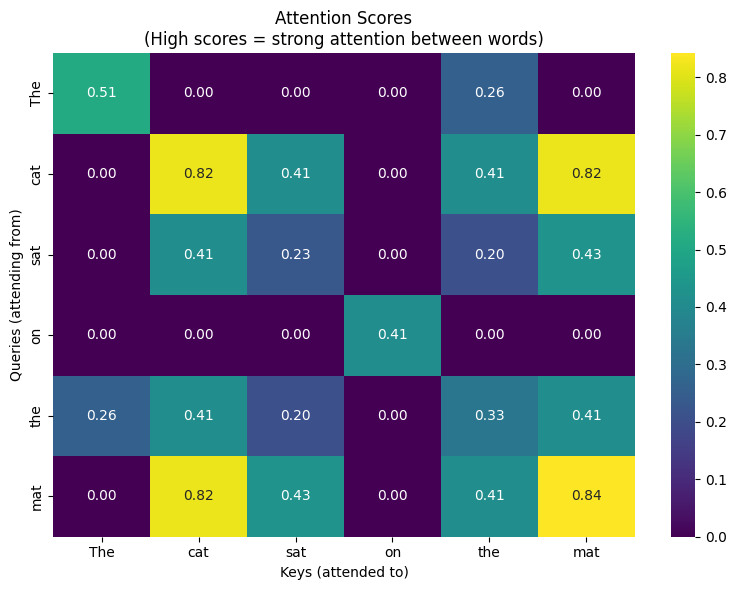


STRONG CONNECTIONS (score ≥ 1.0)
'cat' attends to 'cat': 0.82
'cat' attends to 'mat': 0.82
'mat' attends to 'cat': 0.82
'mat' attends to 'mat': 0.84


In [28]:
# Visualize the attention scores
plt.figure(figsize=(8, 6))
sns.heatmap(attention_scores, annot=True, cmap='viridis', fmt=".2f",
            xticklabels=words, yticklabels=words)
plt.title("Attention Scores\n(High scores = strong attention between words)")
plt.xlabel("Keys (attended to)")
plt.ylabel("Queries (attending from)")
plt.tight_layout()
plt.show()

# Show which word pairs have strong attention
print("\n" + "=" * 50)
print("STRONG CONNECTIONS (score ≥ 1.0)")
print("=" * 50)
for i, word_i in enumerate(words):
    for j, word_j in enumerate(words):
        if attention_scores[i, j] >= 0.7: # Some threshold to highlight the strongest connections
            print(f"'{word_i}' attends to '{word_j}': {attention_scores[i, j]:.2f}")

## When training GPT to predict the next word, it can't look ahead at future words - that's cheating!

Triangular masking blocks each word from seeing words that come after it, forcing the model to predict based only on previous context.

In [54]:
print("\n" + "=" * 50)
print("TRIANGULAR MASKING")
print("=" * 50)

# Create mask with -inf for upper triangle (future positions)
mask = np.triu(np.ones_like(attention_scores) * -np.inf, k=1)
masked_attention_scores = attention_scores + mask

print("Mask (0 = keep, -inf = mask out):")
print(mask)

print("\nMasked attention scores:")
print(masked_attention_scores)


TRIANGULAR MASKING
Mask (0 = keep, -inf = mask out):
[[  0. -inf -inf -inf -inf -inf]
 [  0.   0. -inf -inf -inf -inf]
 [  0.   0.   0. -inf -inf -inf]
 [  0.   0.   0.   0. -inf -inf]
 [  0.   0.   0.   0.   0. -inf]
 [  0.   0.   0.   0.   0.   0.]]

Masked attention scores:
[[0.51031036       -inf       -inf       -inf       -inf       -inf]
 [0.         0.81649658       -inf       -inf       -inf       -inf]
 [0.         0.40824829 0.22963966       -inf       -inf       -inf]
 [0.         0.         0.         0.40824829       -inf       -inf]
 [0.25515518 0.40824829 0.20412415 0.         0.33170174       -inf]
 [0.         0.81649658 0.43376381 0.         0.40824829 0.8420121 ]]


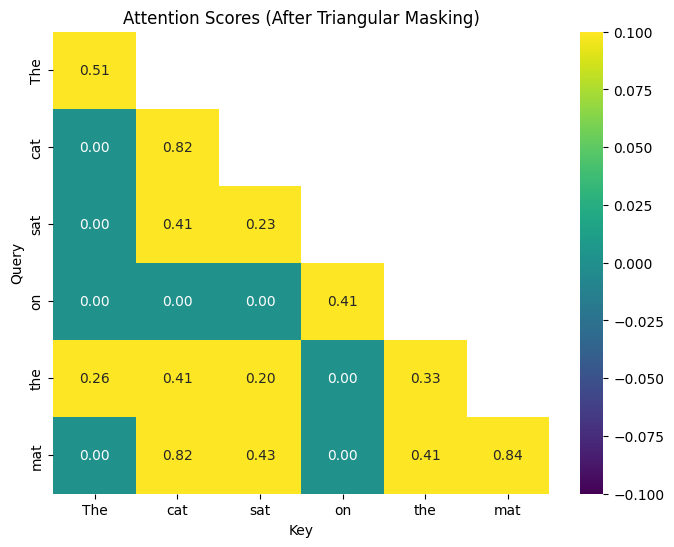

In [65]:
# Visualize masked attention scores
plt.figure(figsize=(8, 6))
sns.heatmap(masked_attention_scores, annot=True, cmap='viridis', fmt=".2f",
            xticklabels=words, yticklabels=words)
plt.title("Attention Scores (After Triangular Masking)")
plt.xlabel("Key")
plt.ylabel("Query")
plt.show()

## After masking, we apply softmax to convert the scores into probabilities that sum to 1, giving us a proper probability distribution over previous words.

## A quick dive into softmax

Softmax converts a list of numbers (scores) into probabilities that sum to 1.

**Input:** Any list of numbers, like `[2, 5, 1]`  
**Output:** Probabilities that sum to 1, like `[0.04, 0.87, 0.09]`

For each score $z_i$ in your list:

$$\text{probability}_i = \frac{e^{z_i}}{\text{sum of all } e^z}$$

#### Example
Given scores `[2, 5, 1]`:
- Calculate: $e^2 \approx 7.4$, $e^5 \approx 146.1 $, $e^1 \approx 2.7$
- Sum: $7.4 + 146.1 + 2.7 = 156.2$
- Probabilities: $[7.4/156.2, 146.4/156.2, 2.7/156.2] = [0.05, 0.94, 0.02]$

The highest score (5) gets the highest probability (94%).

#### Why Use Softmax?

1. **Creates valid probabilities**: All outputs between 0 and 1, sum to 1
2. **Preserves order**: Higher scores → higher probabilities
3. **Differentiable**: Works well with neural networks


#### Numerical Stability Trick

**Problem:** $e^{1000}$ causes overflow!

**Solution:** Subtract the maximum score first.

In [55]:
def stable_softmax(x, axis=-1):
    """
    TODO-1: Implement numerically stable softmax along `axis`.
    Steps:
      1) subtract the row-wise max
      2) exponentiate
      3) divide by row-wise sum
    """
    """Apply softmax along specified axis"""
    # For numerical stability, subtract max
    x_max = np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x - x_max)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

In [56]:
def test_softmax():
    """Simple test case for stable_softmax"""

    # Test input: scores for 3 classes
    x = np.array([2.0, 5.0, 1.0])

    # Run your implementation
    probs = stable_softmax(x)

    # Check if it sums to 1
    assert np.isclose(probs.sum(), 1.0), f"Probabilities don't sum to 1: {probs.sum()}"

    # Check expected values (approximately)
    expected = np.array([0.0466, 0.9362, 0.0172])
    assert np.allclose(probs, expected, atol=0.01), f"Got {probs}, expected ~{expected}"

    print("✅ Test passed!")
    print(f"Input:  {x}")
    print(f"Output: {probs}")
    print(f"Sum:    {probs.sum()}")

    return x, probs


scores, probs = test_softmax()

✅ Test passed!
Input:  [2. 5. 1.]
Output: [0.04661262 0.93623955 0.01714783]
Sum:    1.0


[2. 5. 1.]


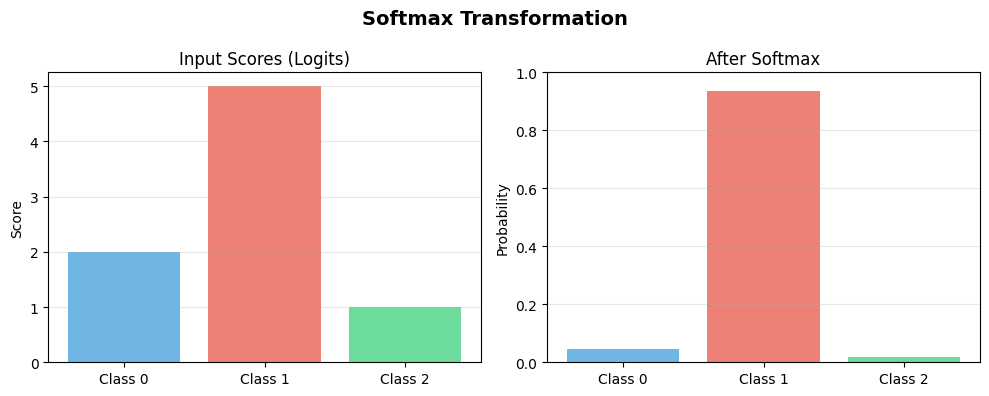


 Try different scores to see how softmax behaves:
Example: test_scores = np.array([1, 1, 1]) for uniform distribution
Example: test_scores = np.array([10, 0, 0]) for very confident prediction


In [30]:
# Visualize how softmax transforms scores to probabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Input scores
classes = ['Class 0', 'Class 1', 'Class 2']
colors = ['#3498db', '#e74c3c', '#2ecc71']

print(scores)
scores = scores # you can vary here to see how softmax behaves, for example: np.array([1, 1, 1])

ax1.bar(classes, scores, color=colors, alpha=0.7)
ax1.set_ylabel('Score')
ax1.set_title('Input Scores (Logits)')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Output probabilities
ax2.bar(classes, probs, color=colors, alpha=0.7)
ax2.set_ylabel('Probability')
ax2.set_title('After Softmax')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

plt.suptitle('Softmax Transformation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Interactive experiment
print("\n Try different scores to see how softmax behaves:")
print("Example: test_scores = np.array([1, 1, 1]) for uniform distribution")
print("Example: test_scores = np.array([10, 0, 0]) for very confident prediction")

## Let us return to our problem to understand where to look at via the QK circuit!

In [57]:
softmax_attention_scores = stable_softmax(masked_attention_scores, axis=1)

print("Softmax normalized attention scores:")
print(softmax_attention_scores)
print("\nRow sums (should all be 1.0):")
print(softmax_attention_scores.sum(axis=1))

Softmax normalized attention scores:
[[1.         0.         0.         0.         0.         0.        ]
 [0.30650784 0.69349216 0.         0.         0.         0.        ]
 [0.26579294 0.39980058 0.33440648 0.         0.         0.        ]
 [0.22201597 0.22201597 0.22201597 0.3339521  0.         0.        ]
 [0.20120597 0.23449218 0.19119581 0.15589363 0.2172124  0.        ]
 [0.10383325 0.23492887 0.16022035 0.10383325 0.15618395 0.24100033]]

Row sums (should all be 1.0):
[1. 1. 1. 1. 1. 1.]


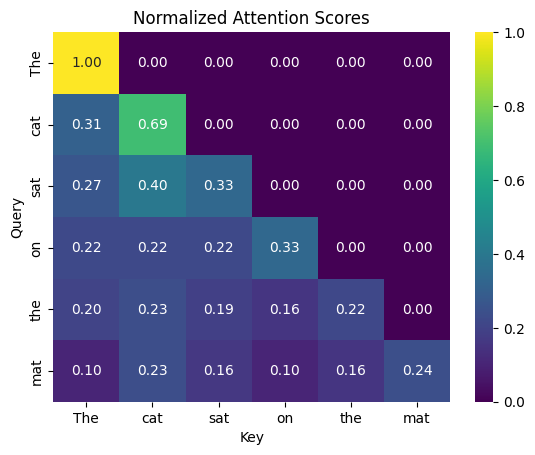

In [58]:
# Visualize the normalized attention scores
sns.heatmap(softmax_attention_scores, annot=True, cmap='viridis', fmt=".2f",   xticklabels=words, yticklabels=words)
plt.title("Normalized Attention Scores")
plt.xlabel("Key")
plt.ylabel("Query")
plt.show()

## Now we are ready to mix information across token positions via the OV circuit!

In [60]:
# Define the weight matrix for values.
# Shape = (d_model, d_v)
W_v = np.random.randn(*input_sequence.T.shape)
print("W_v shape:")
print(W_v.shape)

values = input_sequence @ W_v

print("Values shape:")
print(values.shape)

print("Values:")
print(values)

W_v shape:
(4, 6)
Values shape:
(6, 6)
Values:
[[-0.676922    0.61167629  1.03099952  0.93128012 -0.83921752 -0.30921238]
 [ 0.33126343  0.97554513 -0.47917424 -0.18565898 -1.10633497 -1.19620662]
 [ 0.40626291  0.67812001 -0.03600506  0.50176645  0.18081801 -0.32255988]
 [ 0.36139561  1.53803657 -0.03582604  1.56464366 -2.6197451   0.8219025 ]
 [-0.17282928  0.79361071  0.27591264  0.37281057 -0.97277625 -0.7527095 ]
 [ 0.57189463  1.16589258 -0.27559218  0.40893696 -0.37234947 -0.92066319]]


In [61]:
# Apply the normalized attention scores to the values
output = softmax_attention_scores @ values
print("\nATTENTION OUTPUT (before final projection)")
print("=" * 50)
print("Output shape:", output.shape)
print(np.around(output, 6))



ATTENTION OUTPUT (before final projection)
Output shape: (6, 6)
[[-0.676922  0.611676  1.031     0.93128  -0.839218 -0.309212]
 [ 0.022247  0.864016 -0.016294  0.156692 -1.024461 -0.924336]
 [ 0.088375  0.77937   0.070418  0.341095 -0.604905 -0.668297]
 [ 0.134144  1.016573  0.102556  0.799456 -1.266669 -0.131364]
 [ 0.037952  0.893637  0.142543  0.564676 -1.013411 -0.439757]
 [ 0.220986  0.965974 -0.038333  0.452717 -0.831763 -0.618911]]


Text(50.722222222222214, 0.5, 'Tokens')

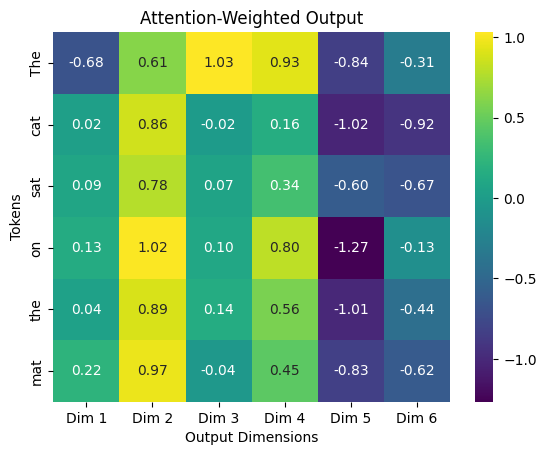

In [62]:
# Heatmap of the attention output (the "OV" circuit)
sns.heatmap(output, annot=True, cmap='viridis', fmt=".2f",
            xticklabels=['Dim 1', 'Dim 2', 'Dim 3', 'Dim 4', 'Dim 5', 'Dim 6'],
            yticklabels=words)
plt.title("Attention-Weighted Output")
plt.xlabel("Output Dimensions")
plt.ylabel("Tokens")

## This new representation is an attention-weighted average of the (value-transformed) words that preceded this word.

In [63]:
# Define the final projection matrix W_o to get back to the residual stream dimension.
# Shape = (d_v, d_model)
W_o = np.array([
    [0.1, 0.0, 0.0, 0.0],
    [0.0, 0.2, 0.0, 0.0],
    [0.0, 0.0, 0.3, 0.0],
    [0.0, 0.0, 0.0, 0.4],
    [0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0]
])

# Project the attention output back to the original d_model dimension
# This output is then added to the original input (residual connection)
final_output = output @ W_o
print("\nFINAL ATTENTION OUTPUT (after final projection)")
print("=" * 50)
print("Final Output shape:", final_output.shape)
print(np.around(final_output, 6))



FINAL ATTENTION OUTPUT (after final projection)
Final Output shape: (6, 4)
[[-0.067692  0.122335  0.3093    0.372512]
 [ 0.002225  0.172803 -0.004888  0.062677]
 [ 0.008838  0.155874  0.021125  0.136438]
 [ 0.013414  0.203315  0.030767  0.319782]
 [ 0.003795  0.178727  0.042763  0.225871]
 [ 0.022099  0.193195 -0.0115    0.181087]]


In [64]:
print("Final output shape:")
print(final_output.shape) # notice it's the dimension of the residual stream!

Final output shape:
(6, 4)


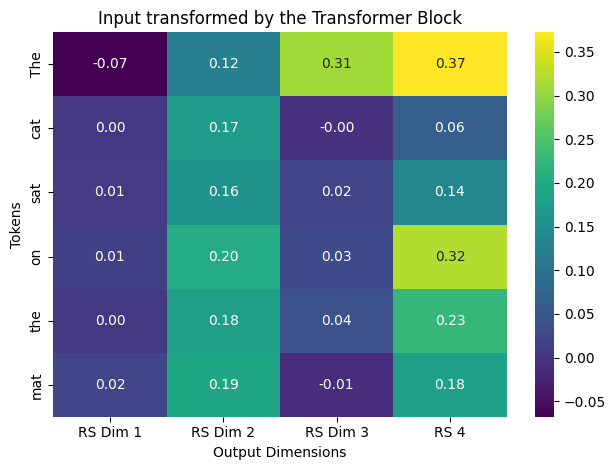

In [66]:
# Heatmap of input after passing through the full attention block
sns.heatmap(final_output, annot=True, cmap='viridis', fmt=".2f",
            xticklabels=['RS Dim 1', 'RS Dim 2', 'RS Dim 3', 'RS 4'],
            yticklabels=words)
plt.title("Input transformed by the Transformer Block")
plt.xlabel("Output Dimensions")
plt.ylabel("Tokens")

plt.tight_layout()
plt.show()


## What happens next?

Let us assume we don't use layer normalization (LayerNorm) for now, but we can always implement it later to scale and shift our residual stream vectors before they enter attention and the MLP layers.

Huge thanks to Stephen McAleese for this awesome & comprehensive resource: https://www.lesswrong.com/posts/XGHf7EY3CK4KorBpw/understanding-llms-insights-from-mechanistic

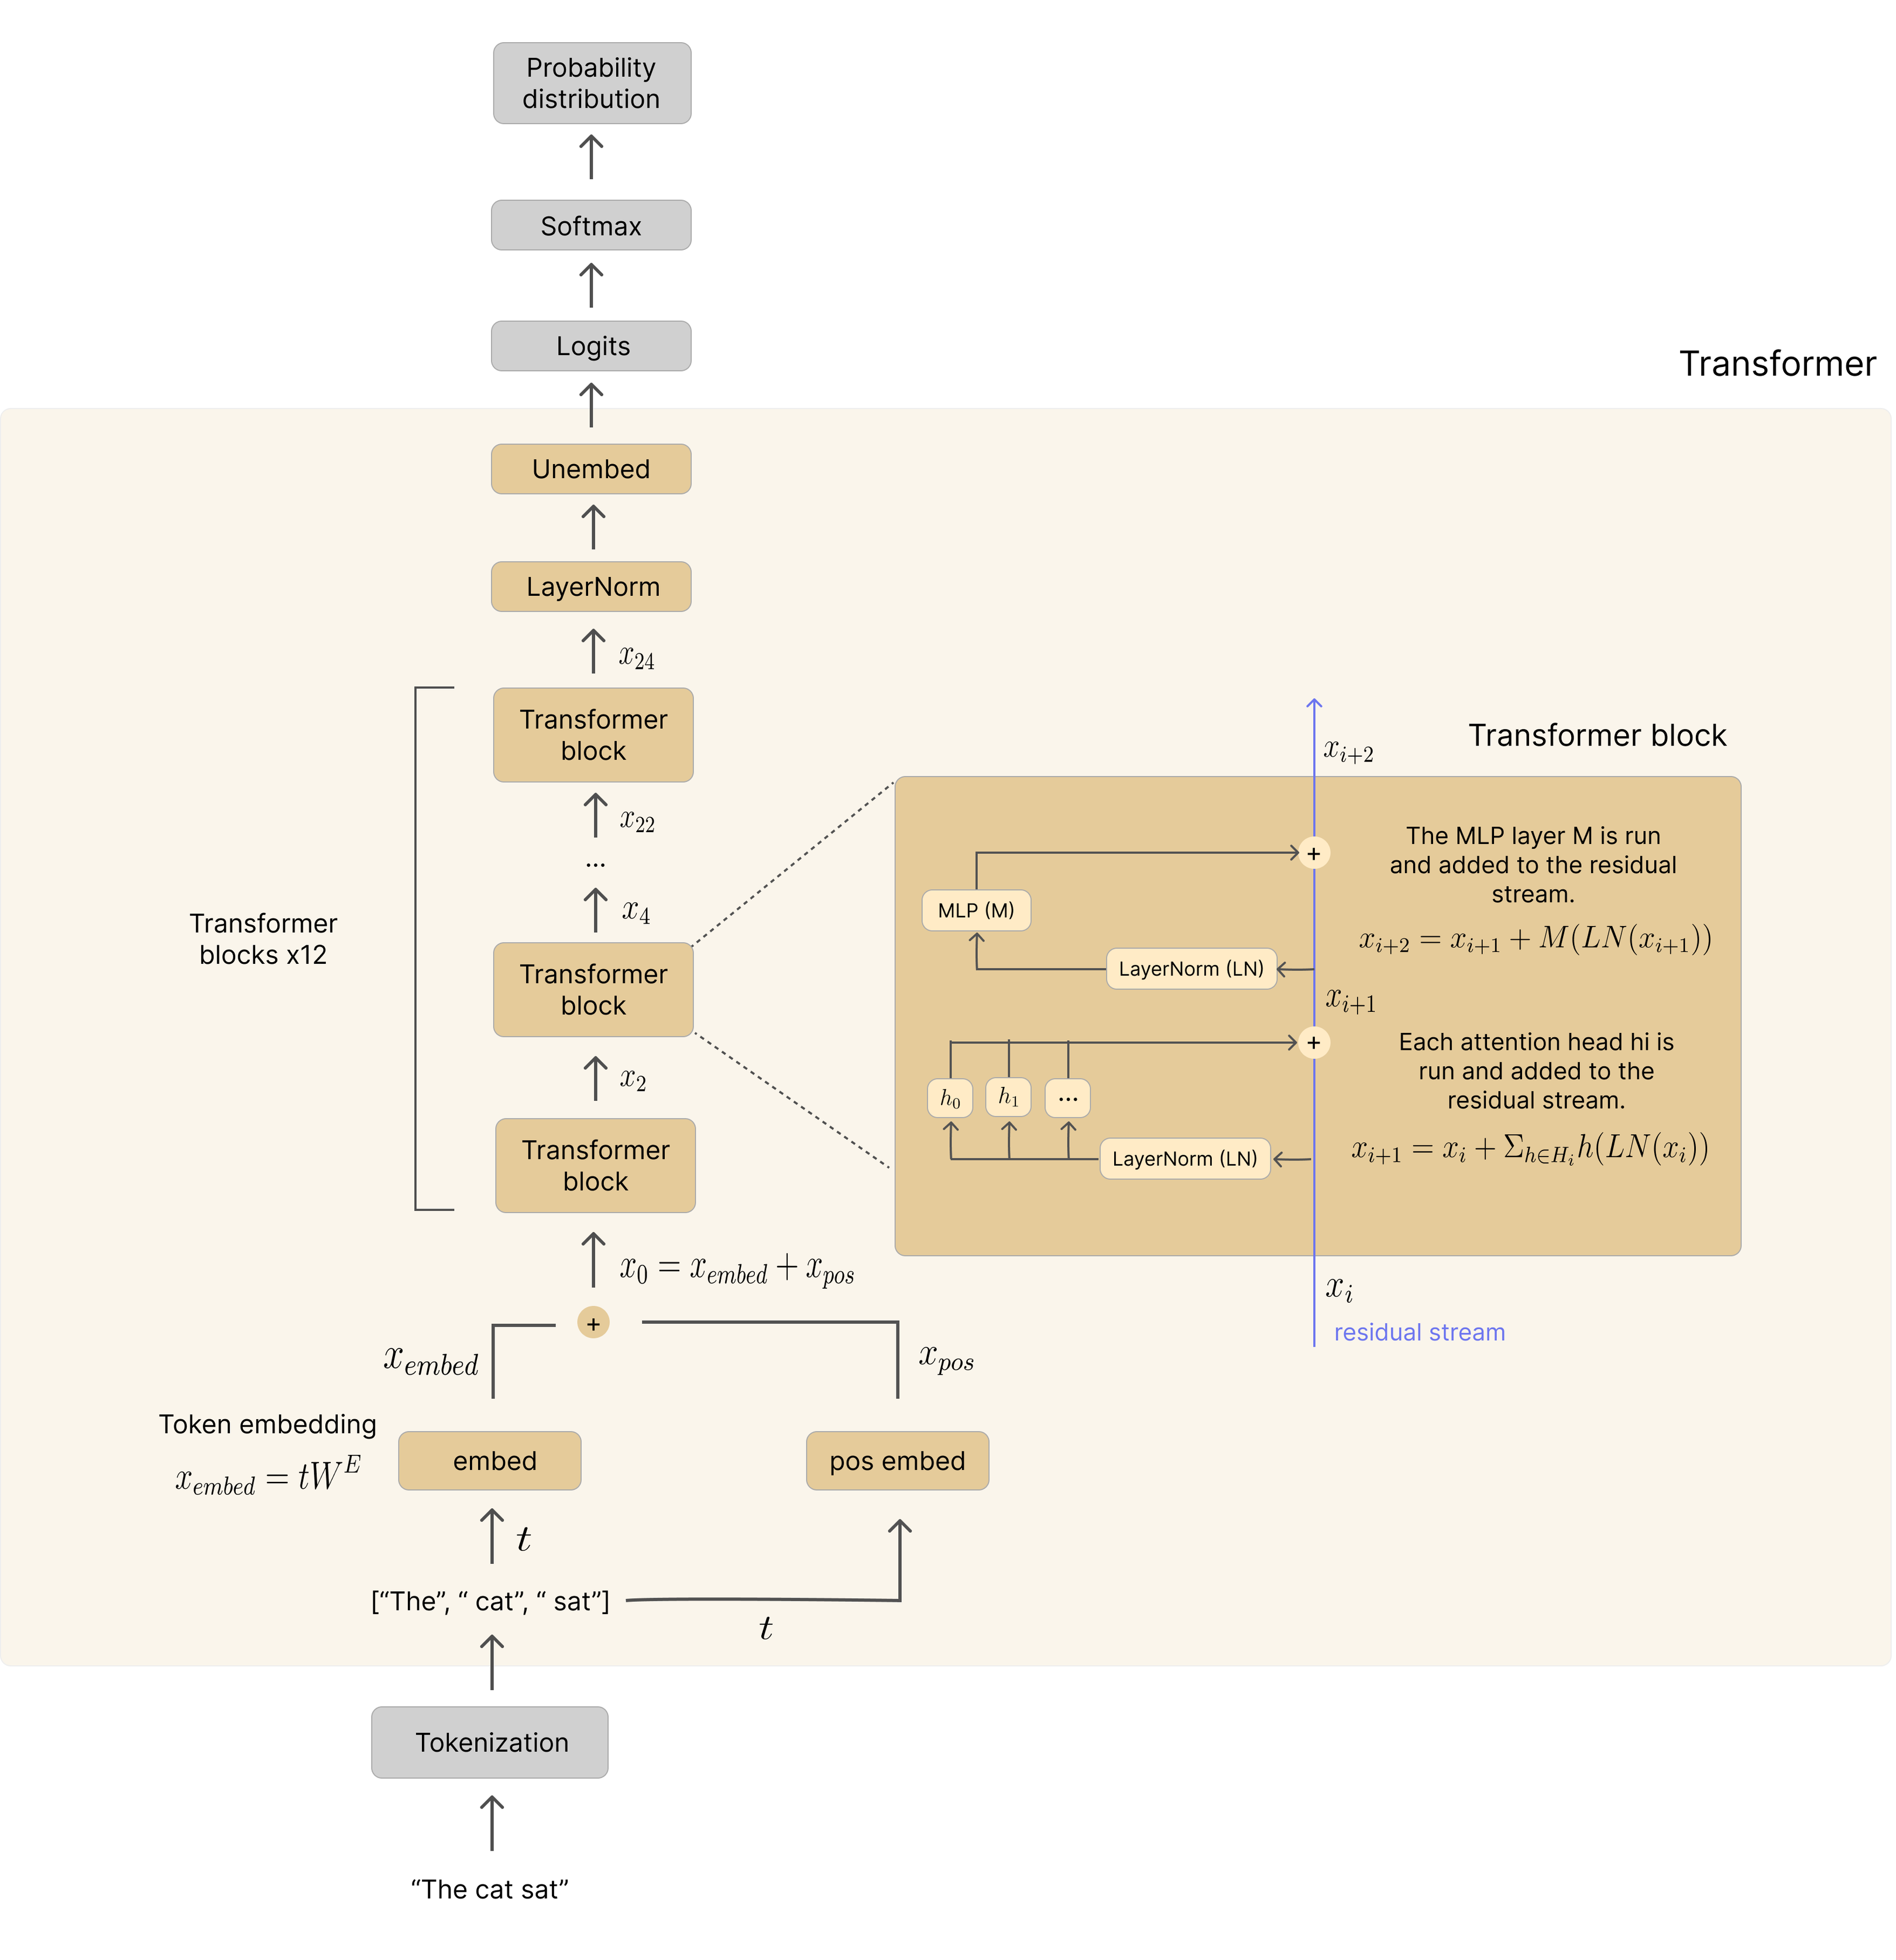

In [ ]:
# Display the positional encoding diagram; credit Stephen McAleese
display(Image("transformer.png", width=800))

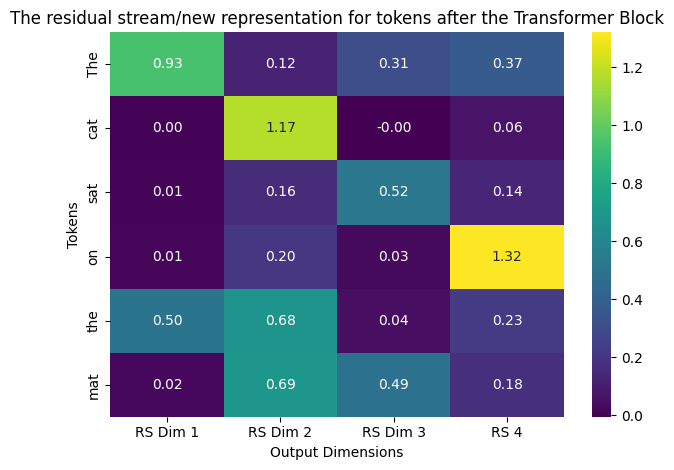

In [ ]:
# Heatmap of input after passing through the full attention block
# we add the input and the output of the Transformer Block to obtain the new representation for tokens

new_representation = input_sequence + final_output
sns.heatmap(new_representation, annot=True, cmap='viridis', fmt=".2f",
            xticklabels=['RS Dim 1', 'RS Dim 2', 'RS Dim 3', 'RS 4'],
            yticklabels=words)
plt.title("The residual stream/new representation for tokens after the Transformer Block")
plt.xlabel("Output Dimensions")
plt.ylabel("Tokens")

plt.tight_layout()
plt.show()


MLP WEIGHT AND BIAS SHAPES
W1 shape: (4, 10)
W2 shape: (10, 4)
b1 shape: (10,)
b2 shape: (4,)

MLP OUTPUT
MLP Output shape: (6, 4)
[[ 1.5495  2.1666 -1.1788  3.958 ]
 [ 0.7251  6.616  -1.5912  3.5006]
 [ 1.1068  2.3718 -2.2156  2.5783]
 [ 4.1261  0.9468 -2.4734  2.8157]
 [ 1.2504  4.6457 -1.4857  3.4171]
 [ 0.8067  3.8927 -1.3585  4.4806]]


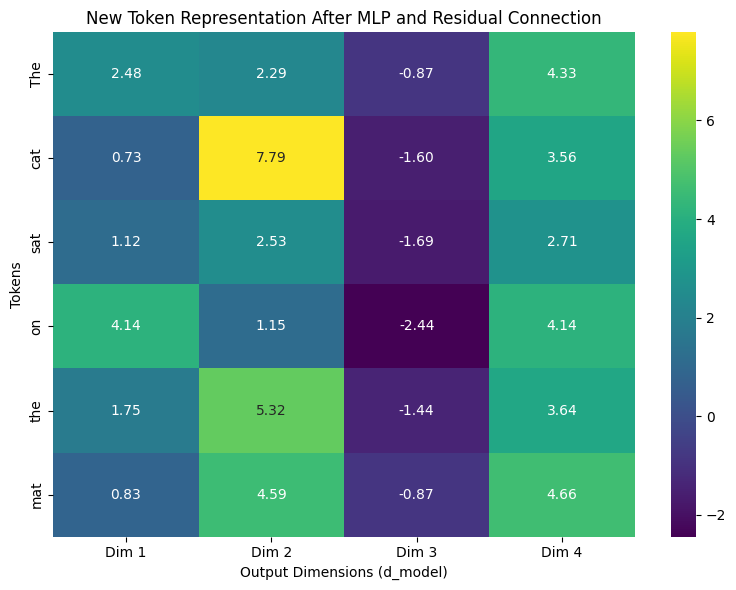

In [79]:
d_model = 4
d_ff = 10

# Define the weight matrices and bias vectors for the MLP.
# W_1 maps from d_model to d_ff
W1 = np.random.randn(d_model, d_ff)
b1 = np.random.randn(d_ff)

# W_2 maps from d_ff back to d_model
W2 = np.random.randn(d_ff, d_model)
b2 = np.random.randn(d_model)

print("MLP WEIGHT AND BIAS SHAPES")
print("=" * 50)
print("W1 shape:", W1.shape)
print("W2 shape:", W2.shape)
print("b1 shape:", b1.shape)
print("b2 shape:", b2.shape)

# Step 1: First linear transformation and bias
mlp_hidden = new_representation @ W1 + b1

# Step 2: Apply the ReLU activation function
relu_output = np.maximum(0, mlp_hidden)

# Step 3: Second linear transformation and bias
mlp_output = relu_output @ W2 + b2

print("\nMLP OUTPUT")
print("=" * 50)
print("MLP Output shape:", mlp_output.shape)
print(np.around(mlp_output, 4))

# Step 4: The residual connection and Layer Normalization
# The MLP output is added back to the input of this sub-layer (final_output).
# We would then apply Layer Normalization.
residual_connection_output = new_representation + mlp_output

plt.figure(figsize=(8, 6))
sns.heatmap(residual_connection_output, annot=True, cmap='viridis', fmt=".2f",
            xticklabels=['Dim 1', 'Dim 2', 'Dim 3', 'Dim 4'],
            yticklabels=words)
plt.title("New Token Representation After MLP and Residual Connection")
plt.xlabel("Output Dimensions (d_model)")
plt.ylabel("Tokens")
plt.tight_layout()
plt.show()


## The unembedding matrix and logits

In [ ]:
# --- 4. UNEMBEDDING AND SOFTMAX FOR LOGITS AND PROBABILITIES ---

# Define a vocabulary. In a real model, this would be much larger.
vocab = ['The', 'cat', 'sat', 'on', 'the', 'mat', 'is', 'a', 'big', 'brown', 'dog']
vocab_size = len(vocab)

# Unembedding matrix maps from d_model to vocab_size.
# The paper suggests this matrix can share weights with the original embedding layer.
unembedding_matrix = np.random.randn(d_model, vocab_size)
print("\nFINAL LAYER DIMENSIONS")
print("=" * 50)
print("Unembedding Matrix shape:", unembedding_matrix.shape)


FINAL LAYER DIMENSIONS
Unembedding Matrix shape: (4, 11)


In [100]:
logits = residual_connection_output @ unembedding_matrix

print("\nLOGITS")
print("=" * 50)
print("Logits shape:", logits.shape)
print(np.around(logits, 4))


LOGITS
Logits shape: (6, 11)
[[  2.3134   6.1168  -2.0102   0.2026  -1.1467  -5.481    8.1325  -1.2755
    7.5017   3.4951  -1.0217]
 [  9.4165  -3.6246  -8.6087  -3.1647  -0.4902  -1.5325   0.6184  -0.7307
    2.131   -2.6441 -10.8304]
 [  3.8575   3.7189  -1.623   -1.3363   0.2212  -5.1465   3.285   -1.0159
    4.7511   0.2852  -2.2491]
 [  1.692    8.5499   1.3255  -2.5895   1.131  -13.0272   9.5437  -0.8732
    9.7831   4.5809   4.3564]
 [  6.2307   0.11    -5.4112  -2.3766  -0.3366  -4.1564   3.6804  -0.7273
    4.2685   0.0357  -5.7864]
 [  5.5763   4.0231  -5.3045   0.7647  -1.994   -1.4904   5.3505  -1.8353
    5.9439   0.7002  -7.1916]]


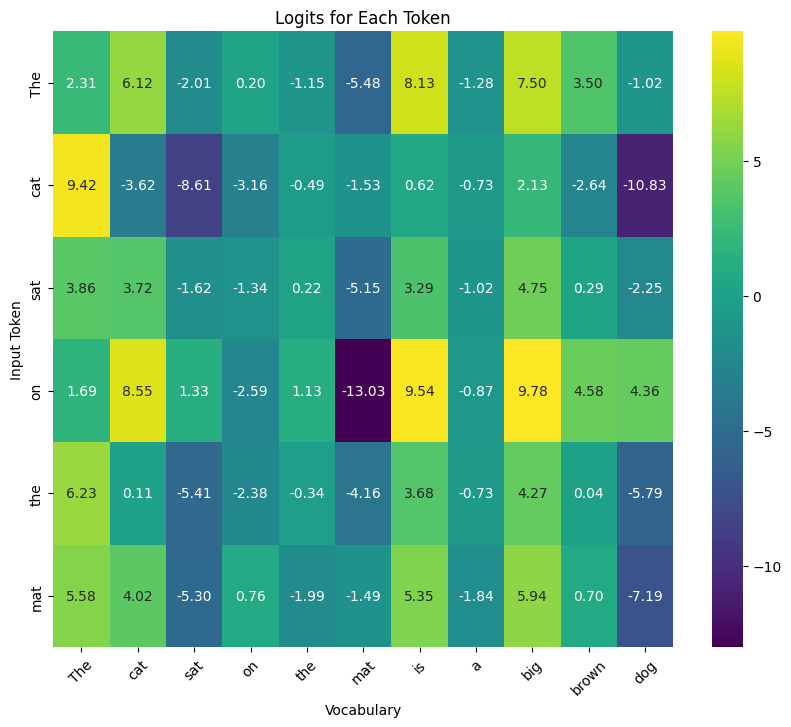

In [101]:
# Plot the logits heatmap
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(logits, annot=True, cmap='viridis', fmt=".2f",
            xticklabels=vocab, yticklabels=words)
plt.title("Logits for Each Token")
plt.xlabel("Vocabulary")
plt.ylabel("Input Token")
plt.tick_params(axis='x', rotation=45)
plt.show()

In [102]:
probabilities = stable_softmax(logits, axis=1)
print("\nPROBABILITIES (SOFTMAX)")
print("=" * 50)
print("Probabilities shape:", probabilities.shape)
print(np.around(probabilities, 4))


PROBABILITIES (SOFTMAX)
Probabilities shape: (6, 11)
[[1.800e-03 7.940e-02 0.000e+00 2.000e-04 1.000e-04 0.000e+00 5.957e-01
  0.000e+00 3.170e-01 5.800e-03 1.000e-04]
 [9.990e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e-04
  0.000e+00 7.000e-04 0.000e+00 0.000e+00]
 [2.019e-01 1.758e-01 8.000e-04 1.100e-03 5.300e-03 0.000e+00 1.139e-01
  1.500e-03 4.934e-01 5.700e-03 4.000e-04]
 [1.000e-04 1.395e-01 1.000e-04 0.000e+00 1.000e-04 0.000e+00 3.768e-01
  0.000e+00 4.787e-01 2.600e-03 2.100e-03]
 [8.160e-01 1.800e-03 0.000e+00 1.000e-04 1.100e-03 0.000e+00 6.370e-02
  8.000e-04 1.147e-01 1.700e-03 0.000e+00]
 [2.881e-01 6.090e-02 0.000e+00 2.300e-03 1.000e-04 2.000e-04 2.298e-01
  2.000e-04 4.160e-01 2.200e-03 0.000e+00]]


In [103]:
last_token_probabilities = probabilities[-2, :]
predicted_token_index = np.argmax(last_token_probabilities)
predicted_token = vocab[predicted_token_index]

print("\nPREDICTION FOR THE LAST TOKEN ('the')")
print("=" * 50)
print(f"Predicted next token: '{predicted_token}' (index {predicted_token_index})")
print("Full probability distribution:")
for i, prob in enumerate(last_token_probabilities):
    print(f"  '{vocab[i]}': {prob:.4f}")


PREDICTION FOR THE LAST TOKEN ('the')
Predicted next token: 'The' (index 0)
Full probability distribution:
  'The': 0.8160
  'cat': 0.0018
  'sat': 0.0000
  'on': 0.0001
  'the': 0.0011
  'mat': 0.0000
  'is': 0.0637
  'a': 0.0008
  'big': 0.1147
  'brown': 0.0017
  'dog': 0.0000


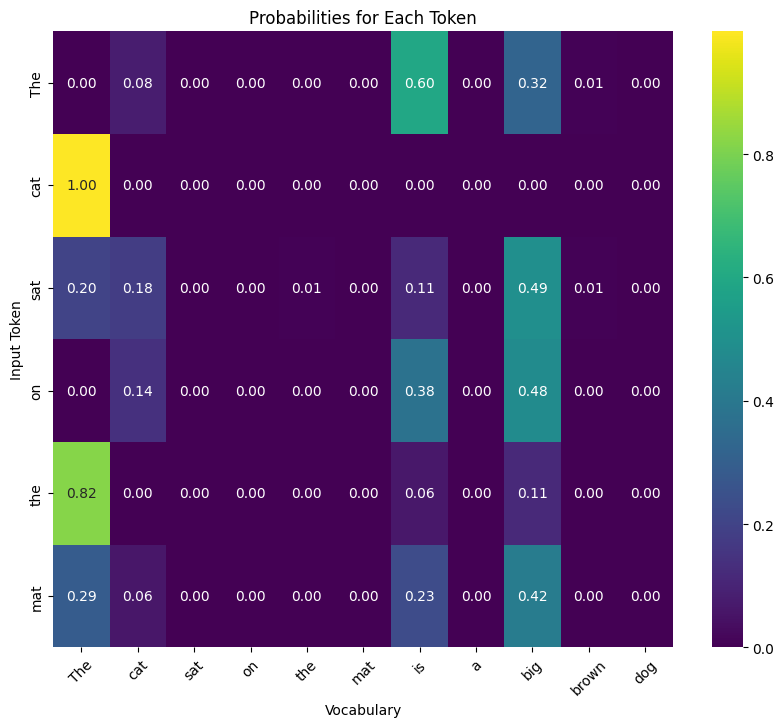

In [104]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(probabilities, annot=True, cmap='viridis', fmt=".2f",
            xticklabels=vocab, yticklabels=words)
plt.title("Probabilities for Each Token")
plt.xlabel("Vocabulary")
plt.ylabel("Input Token")
plt.tick_params(axis='x', rotation=45)
plt.show()


### P3.2 Discuss whether the weights of the unembedding matrix need to be updated based on this result.